# 报告项目

In [2]:
# 原始数据处理
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from time import time
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import fbeta_score, accuracy_score

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
import visuals as vs
import zipfile, os
from IPython.display import display # 使得我们可以对DataFrame使用display()函数

# 设置以内联的形式显示matplotlib绘制的图片（在notebook中显示更美观）
%matplotlib inline
    

# 载入整个客户数据集
data = pd.read_csv("train.csv")
data["StateHoliday"] = data["StateHoliday"].replace(["0","a","b","c"],[0,1,2,3])


print "总条数:"+str(len(data))
#data = data[data['Sales'] >0]
#print "去除0的条数:"+str(len(data))


prices = data['Sales']

#prices = data['Sales']
#features = data.drop(['Sales','Date','Customers'], axis = 1)

# TODO: Minimum price of the data
#目标：计算价值的最小值
minimum_price = np.min(prices)

# TODO: Maximum price of the data
#目标：计算价值的最大值
maximum_price = np.max(prices)

# TODO: Mean price of the data
#目标：计算价值的平均值
mean_price = np.mean(prices)

# TODO: Median price of the data
#目标：计算价值的中值
median_price = np.median(prices)

# TODO: Standard deviation of prices of the data
#目标：计算价值的标准差
std_price = np.std(prices)

# Show the calculated statistics
#目标：输出计算的结果
print "Sales最小值: {:,.2f}".format(minimum_price)
print "Sales最大值: {:,.2f}".format(maximum_price)
print "Sales均值: {:,.2f}".format(mean_price)
print "Sales中值 {:,.2f}".format(median_price)
print "Sales标准差: {:,.2f}".format(std_price)

ktest = pd.read_csv("test.csv")
ktest["StateHoliday"] = ktest["StateHoliday"].replace(["0","a","b","c"],[0,1,2,3])


总条数:1017209
Sales最小值: 0.00
Sales最大值: 41,551.00
Sales均值: 5,773.82
Sales中值 5,744.00
Sales标准差: 3,849.92


In [3]:
#合并数据
store = pd.read_csv("store.csv")
store["StoreType"] = store["StoreType"].replace(["a","b","c","d"],[1,2,3,4])
store["Assortment"] = store["Assortment"].replace(["a","b","c"],[1,2,3])

store_dic = dict(list(store.groupby('Store')))

#print features["Store"]

def tof2(pb):
    npb = pb.copy()
    
    ss = dict()
    for s in store:
        #print s
        if s!="Store":
            #print s
            ss[s]=[]     

    #print ss
    
    #print npb
    #print len(npb)
    npb['Year']  = npb['Date'].apply(lambda x: int(str(x)[:4]))
    npb['Month'] = npb['Date'].apply(lambda x: int(str(x)[5:7]))
    
    for i in range(0,npb.shape[0]):
        #print i
        #print npb['Date'][:4]

        #npb["StateHoliday"] = npb["StateHoliday"].replace(["a","b","c"],[1,2,3])
        s = store_dic[npb["Store"][i]]
        for sc in ss:
            #sc = str(sc)
            #print sc+" "+str(s[sc].values[0])
            #print s[sc]
            #ss["StoreType"].append(s[sc].values[0])
            ss[sc].append(s[sc].values[0])
            #print ss[sc].values
        #    print sc
            #print sc
    for sc in ss:
        npb[sc]=ss[sc]
    npb = npb.drop(['PromoInterval'], axis = 1)
    
    return npb

#print store.head(1)
#print ktest.head(1)
testdata = tof2(data)

print "完成合并数据"
#print testdata.head(1)
#testdata["StateHoliday"] = testdata["StateHoliday"].replace(["a","b","c"],[1,2,3])

完成合并数据


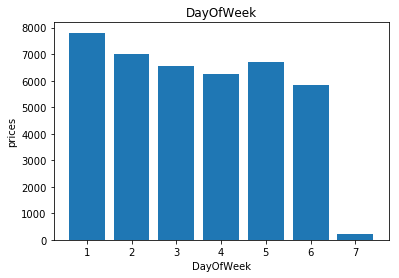

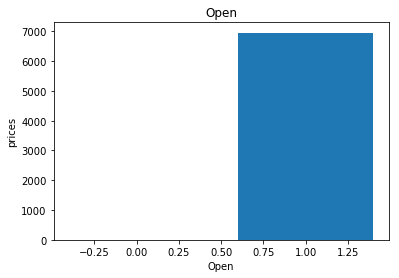

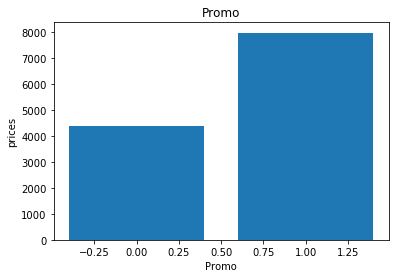

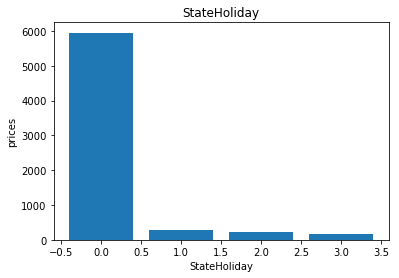

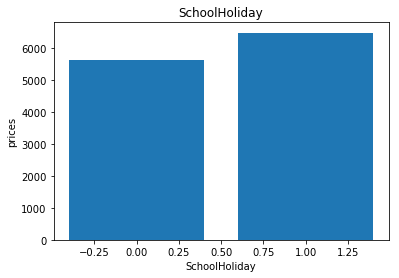

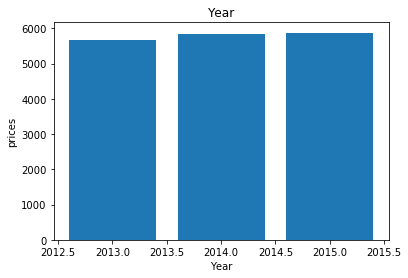

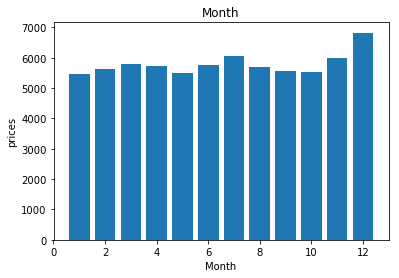

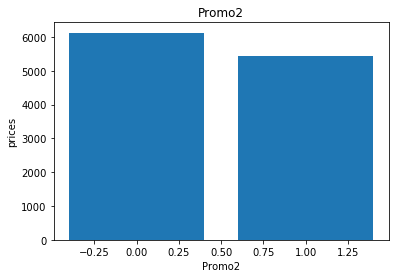

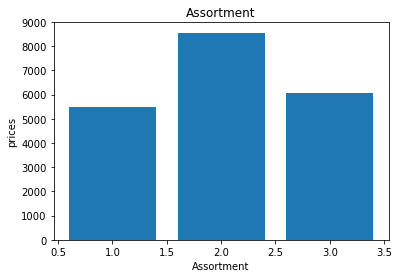

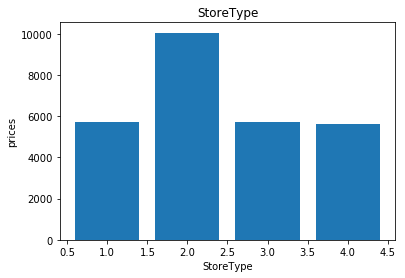

In [5]:
import matplotlib.pyplot as plt

features = testdata.drop(['Store','Sales','Date','Customers','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek','CompetitionDistance'], axis = 1)

for i,col in enumerate(features.columns):
    #plt.subplot(2,3,i+1)
    #print col
    g = testdata.groupby(col)["Sales"].mean()
    #print g
    
    #plt.plot(features[col],prices,'.')
    plt.bar(g.index,g.values)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')
    plt.show()
    #fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))
    #ax1 = x.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
    #ax1.set_xticks(range(len(average_sales)))
    #ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)




In [9]:
#拆分数据
X_train, X_test, y_train, y_test = train_test_split( features, prices, test_size=0.2, random_state=0)

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def RMSPE(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def outcvszip(clf,num,x_test=X_test,ktestdata=testdata):
    name = clf.__class__.__name__+"_"+str(num)
    y_pred = clf.predict(x_test)
    print name+" 的RMSPE得分:"+str(RMSPE(y_test, y_pred))
    
    predictions_test = clf.predict(ktestdata)
    d = {'Id':pd.Series(range(1,len(predictions_test)+1),index=range(1,len(predictions_test)+1)),'Sales':pd.Series(predictions_test,index=range(1,len(predictions_test)+1))}
    df = pd.DataFrame(d)
                                                                                                          
    #print predictions_test
    #print df
    csvname = name+"_v2.csv"
    df.to_csv(csvname,index=False)#header=False
    
    zipFile = zipfile.ZipFile(name+'_v2.zip', 'w')
    zipFile.write(csvname, compress_type=zipfile.ZIP_DEFLATED)
    zipFile.close()
    #print str(y_test[0])+" "+ str(predictions_test[0])
    print name+"写入文件完成"

#'Store',
#features = testdata.drop(['Sales','Date','Customers','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek','CompetitionDistance'], axis = 1)

#X_train, X_test, y_train, y_test = train_test_split( features, prices, test_size=0.2, random_state=0)

In [10]:
def testpredict(dic,X):
    predictions_test = []
    for s in X["Store"]:
        predictions_test.append(dic[s])
    return np.array(predictions_test)

def test(dic,name):
    
    X_train, X_test, y_train, y_test = train_test_split( data, prices, test_size=0.2, random_state=0)
    
    predictions_test = testpredict(dic,X_test)
    print name+" 的本地RMSPE得分:"+str(RMSPE(y_test, predictions_test))
    
    predictions_test = testpredict(dic,ktest)
        
    d = {'Id':pd.Series(range(1,len(predictions_test)+1),index=range(1,len(predictions_test)+1)),'Sales':pd.Series(predictions_test,index=range(1,len(predictions_test)+1))}
    df = pd.DataFrame(d)
                                                                                                          
    #print predictions_test
    #print df
    csvname = name+"_v2.csv"
    df.to_csv(csvname,index=False)#header=False
    
    zipFile = zipfile.ZipFile(name+'_v2.zip', 'w')
    zipFile.write(csvname, compress_type=zipfile.ZIP_DEFLATED)
    zipFile.close()
    #print str(y_test[0])+" "+ str(predictions_test[0])
    print name+"写入文件完成"
    


meandic = data.groupby("Store")["Sales"].mean()
mediandic =  data.groupby("Store")["Sales"].median()

test(meandic,"mean")
test(mediandic,"median")
 
#print meandic[2]

mean 的本地RMSPE得分:0.547185081047
mean写入文件完成
median 的本地RMSPE得分:0.516694408912
median写入文件完成


In [11]:
clfs = []
clfs.append(LinearRegression())
#clfs.append(tree.DecisionTreeClassifier(random_state = 0))
clfs.append(tree.DecisionTreeRegressor(random_state = 0))
clfs.append(RandomForestRegressor(random_state=0))


num=features.shape[0]
for clf in clfs:
    start = time()
    #clf.fit(features.head(n=20000),prices.head(n=20000))
    #clf = clf.fit(features.head(n=num),prices.head(n=num))
    clf = clf.fit(X_train,y_train)
    end = time()
    print clf.__class__.__name__+"使用训练数量:"+str(num)+" 用时:"+str(end-start)

LinearRegression使用训练数量:1017209 用时:0.392040967941
DecisionTreeRegressor使用训练数量:1017209 用时:1.62742185593
RandomForestRegressor使用训练数量:1017209 用时:13.495262146


In [12]:
testdata1 =  tof2(ktest)
testdata1 = testdata1.drop(['Id','Store','Date','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek','CompetitionDistance'], axis = 1)

#X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=0)

for clf in clfs:
    outcvszip(clf,"1",x_test=X_test,ktestdata=testdata1)

LinearRegression_1 的RMSPE得分:0.551757814743
LinearRegression_1写入文件完成
DecisionTreeRegressor_1 的RMSPE得分:0.336798060153
DecisionTreeRegressor_1写入文件完成
RandomForestRegressor_1 的RMSPE得分:0.336453473775
RandomForestRegressor_1写入文件完成


In [17]:
def performance_metric(y_true, y_predict):
    score = RMSPE(y_true,y_predict) 
    # Return the score
    return score

scoring_fnc = make_scorer(performance_metric)

#X_train, X_test, y_train, y_test = train_test_split( features, prices, test_size=0.2, random_state=0)
#X_train2, X_test2, y_train2, y_test2 = train_test_split( features, prices, test_size=0.2, random_state=1)

params = []
params.append({'fit_intercept':[True,False],'normalize':[True,False],'copy_X':[True,False],'n_jobs':[-1]})
params.append({'max_depth': [None,1,3,5],'max_features':['auto','sqrt','log2'],'min_samples_split':[100,500,1000,2000],'min_samples_leaf':[100,500,1000,2000],'random_state':[0]})#,'presort':[True,False]
params.append({'max_depth':[1,3,5],'n_jobs':[-1],'min_samples_split':[1000,2000],'min_samples_leaf':[1000,2000],'random_state':[0]})#,'max_depth':[None,1,3,5]

oclfs = []

for i in range(0,len(clfs)):
    #X_train, X_test, y_train, y_test
    clf = clfs[i]
    p = params[i]
    name = clf.__class__.__name__
    
    #if name== 'RandomForestRegressor':
    start = time()
    grid =  GridSearchCV(clf, p, scoring_fnc, cv=5,n_jobs=-1) 
    grid = grid.fit(X_train, y_train)   
    oclf = grid.best_estimator_    
    oclfs.append(oclf)
    
    y_pred = oclf.predict(X_test)
    
    end = time()
    print name+" 优化后的RMSPE得分:"+str(RMSPE(y_test, y_pred))+" 用时:"+str(end-start)

#LinearRegression 优化后的RMSPE得分:0.551933640687 用时:24.5874650478
#DecisionTreeRegressor 优化后的RMSPE得分:1.31691570329 用时:651.78999114

LinearRegression 优化后的RMSPE得分:0.551933640687 用时:25.0400428772
DecisionTreeRegressor 优化后的RMSPE得分:1.31691570329 用时:684.983707905
RandomForestRegressor 优化后的RMSPE得分:0.406119104621 用时:152.300956011


In [18]:
#第2次训练
for clf in oclfs:
    #X_train, X_test, y_train, y_test
    outcvszip(clf,"2",x_test=X_test,ktestdata=testdata1)
    #outcvszip(clf,2)

LinearRegression_2 的RMSPE得分:0.551933640687
LinearRegression_2写入文件完成
DecisionTreeRegressor_2 的RMSPE得分:1.31691570329
DecisionTreeRegressor_2写入文件完成
RandomForestRegressor_2 的RMSPE得分:0.406119104621
RandomForestRegressor_2写入文件完成


Feature ranking:
1. feature 1 DayOfWeek (0.719652)
2. feature 2 Open (0.113780)
3. feature 0 Promo (0.047766)
4. feature 6 StateHoliday (0.035285)
5. feature 9 SchoolHoliday (0.032428)
6. feature 8 Year (0.018974)
7. feature 7 Month (0.013875)
8. feature 5 Promo2 (0.009048)
9. feature 4 Assortment (0.008060)
10. feature 3 StoreType (0.001132)


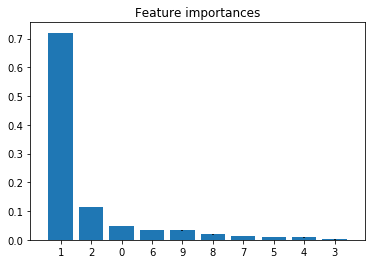

In [42]:
forest = clfs[2]
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

#print forest
#print X_train.columns

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],X_train.columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()